In [1]:
#6!pip install torch torchvision
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from IPython.display import clear_output

# Download and load the CIFAR10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transforms.ToTensor())

# Download and load the CIFAR10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

# Define data split percentages
train_split_percentage = 0.5
importance_split_percentage = 0.1
unlearning_split_percentage = 0.3
validation_split_percentage = 0.1

In [3]:
total_train_samples = len(train_dataset)

train_samples = int(total_train_samples * train_split_percentage)
importance_samples = int(total_train_samples * importance_split_percentage)
validation_samples = int(total_train_samples * validation_split_percentage)
unlearning_samples= total_train_samples - (train_samples + importance_samples + validation_samples)

# The remaining samples will form a temporary test set
test_samples = len(test_dataset)

train_subset, importance_subset, validation_subset, unlearning_subset= torch.utils.data.random_split(
    train_dataset, [train_samples, importance_samples, validation_samples, unlearning_samples]
)

print(f"Number of samples in training subset: {len(train_subset)}")
print(f"Number of samples in importance subset: {len(importance_subset)}")
print(f"Number of samples in validation subset: {len(validation_subset)}")
print(f"Number of samples in unlearning subset: {len(unlearning_subset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of samples in training subset: 25000
Number of samples in importance subset: 5000
Number of samples in validation subset: 5000
Number of samples in unlearning subset: 15000
Number of samples in test dataset: 10000


In [4]:
# Define the mean and standard deviation for CIFAR10 for normalization
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# Transformations for the training dataset (including augmentation)
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Transformations for the importance and test datasets (no augmentation)
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Apply the transformations to the respective subsets
train_subset.dataset.transform = train_transforms
validation_subset.dataset.transform = eval_transforms
importance_subset.dataset.transform = eval_transforms
test_dataset.transform = eval_transforms

print("Transformations defined and applied to datasets.")

Transformations defined and applied to datasets.


In [5]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 100

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
importance_loader = DataLoader(importance_subset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
unlearn_loader = DataLoader(unlearning_subset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in importance loader: {len(importance_loader)}")
print(f"Number of batches in validation loader: {len(validation_loader)}")
print(f"Number of batches in unlearning loader: {len(unlearn_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

DataLoaders created with batch size: 100
Number of batches in training loader: 250
Number of batches in importance loader: 50
Number of batches in validation loader: 50
Number of batches in unlearning loader: 15000
Number of batches in test loader: 100


In [6]:
import torch.nn as nn
from torchvision.models import resnet18

# Instantiate the ResNet18 model
model = resnet18(pretrained=False)

# Modify the final fully connected layer for CIFAR10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Print the model architecture
print(model)
print("Number of model parameters:", sum(p.numel() for p in model.parameters()))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and optimizer (SGD) defined.")


Loss function (CrossEntropyLoss) and optimizer (SGD) defined.


In [8]:
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import matplotlib.pyplot as plt

def display_loss(loss):
    plt.figure(figsize=(12, 6))
    plt.plot(loss)
    plt.title("Training Loss Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.xlim([0, len(loss)])
    plt.savefig("loss_cifar10_resnet.png", dpi=300)
    plt.show()

def display_epochloss(train_loss, val_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlim([0, len(train_loss)-1])
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig("epochloss_cifar10_resnet.png", dpi=300)
    plt.show()

def display_accuracy(accuracy):
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy)
    plt.title("Test Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.xlim([0, len(accuracy)-1])
    plt.ylim([0, 100])
    plt.savefig("accuracy_cifar10_resnet.png", dpi=300)
    plt.show()


In [10]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    class_accuracies = [0 for _ in range(10)]
    class_counts = [0 for _ in range(10)]
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                class_counts[label] += 1
                if predicted[i] == label:
                    class_accuracies[label] += 1

    accuracy = 100 * correct / total
    for i in range(10):
        if class_counts[i] > 0:
            class_accuracies[i] = 100 * class_accuracies[i] / class_counts[i]
        else:
            class_accuracies[i] = 0.0
        
    model.train()
    return accuracy, class_accuracies

def compute_val_loss(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    model.train()
    return avg_loss

[27, 250] loss: 0.071


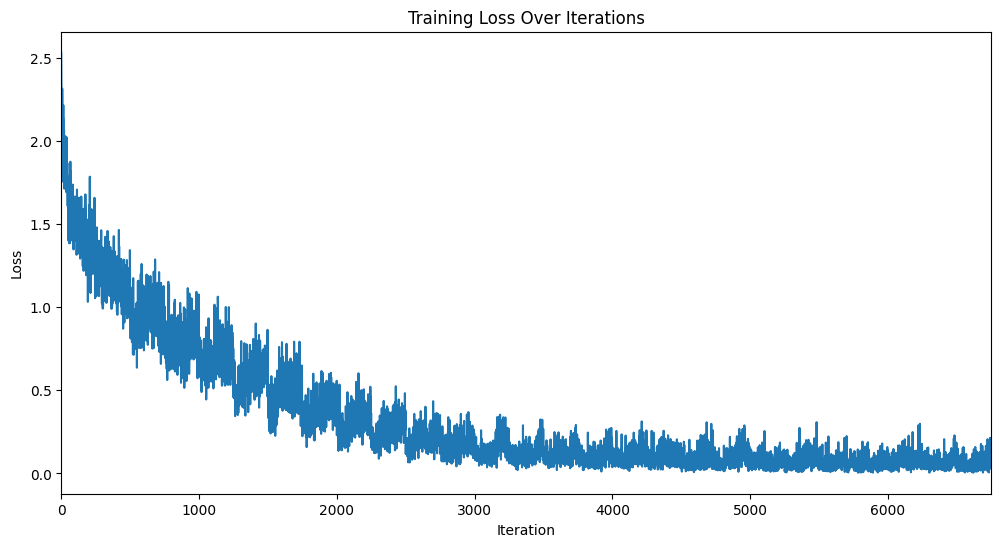

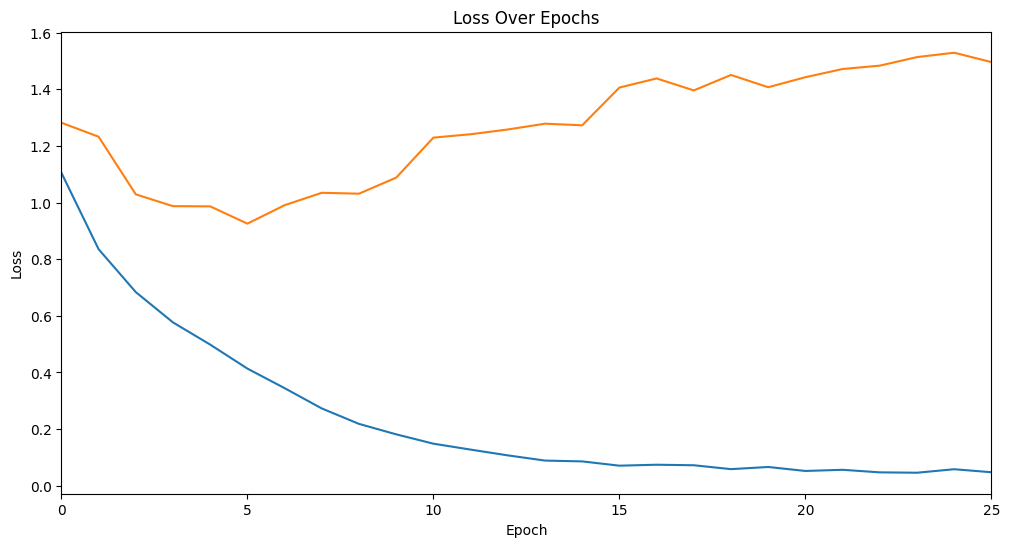

In [11]:


print(f"Training model on {device}")

# Set the model to training mode
model.train()

loss_values = []
epoch_losses = []

val_losses = []

best_loss = float('inf')
best_epoch = -1

best_acc = 0.0
best_epoch_acc = -1

test_accuracies = []
test_class_accuracies = []

for epoch in range(num_epochs):  # Loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0.0
    count = 0

    for i, data in enumerate(train_loader, 0):
        clear_output(wait=True)

        # Get the inputs and labels
        inputs, labels = data

        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Perform a forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())

        # Perform a backward pass
        loss.backward()

        # Update the model's weights
        optimizer.step()

        # Print loss statistics
        running_loss += loss.item()
        epoch_loss += loss.item()
        count += 1

        if i % 50 == 49:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
            # Display the loss curve
            display_loss(loss_values)
            display_epochloss(epoch_losses, val_losses)
            clear_output(wait=True)
  
    epoch_losses.append(epoch_loss/350)

    val_loss = compute_val_loss(model, validation_loader, criterion)

    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch

        torch.save(model.state_dict(), 'best_cifar10_resnet18.pth')

    val_losses.append(val_loss)

    # Compute accuracy on the test set
    test_accuracy, class_accuracy = compute_accuracy(model, test_loader)
    test_accuracies.append(test_accuracy)
    test_class_accuracies.append(class_accuracy)

    if test_accuracy > best_acc:
        best_acc = test_accuracy
        best_epoch_acc = epoch
        torch.save(model.state_dict(), 'best_acc_cifar10_resnet18.pth')

    display_accuracy(test_accuracies)
   


print('Finished Training')

In [12]:
#save the model
torch.save(model.state_dict(), 'cifar10_resnet18.pth')

In [13]:
accuracy, class_accuracies = compute_accuracy(model, test_loader)

print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')
print('Class-wise accuracies:')
for i in range(10):
    print(f'Class {i}: {class_accuracies[i]:.2f} %')

Accuracy of the model on the 10000 test images: 69.96 %
Class-wise accuracies:
Class 0: 75.80 %
Class 1: 87.10 %
Class 2: 60.20 %
Class 3: 52.50 %
Class 4: 61.80 %
Class 5: 62.00 %
Class 6: 70.10 %
Class 7: 76.70 %
Class 8: 81.00 %
Class 9: 72.40 %


In [14]:
# Split importance set by class

from collections import defaultdict

# Get class names from the dataset
class_names = train_dataset.classes

# Create a dictionary to hold samples for each class
importance_by_class = defaultdict(list)

# Iterate through the importance_subset and split by class
for idx in importance_subset.indices:
    # Get the original dataset item and its class label
    # Note: importance_subset is a Subset, so we need to access its dataset attribute
    # and then get the item by its original index.
    _, label = train_dataset[idx]
    class_name = class_names[label]
    importance_by_class[class_name].append(train_dataset[idx])

print("Importance set split by class:")
for class_name, samples in importance_by_class.items():
    print(f"  Class '{class_name}': {len(samples)} samples")

Importance set split by class:
  Class 'cat': 517 samples
  Class 'dog': 503 samples
  Class 'deer': 507 samples
  Class 'ship': 497 samples
  Class 'frog': 493 samples
  Class 'bird': 505 samples
  Class 'automobile': 490 samples
  Class 'horse': 472 samples
  Class 'airplane': 519 samples
  Class 'truck': 497 samples


In [115]:
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [116]:
# Compute parameter L1 norms for each class

# Create DataLoaders with batch_size=1 for per-datapoint gradient analysis
per_datapoint_dataloaders = {}
for class_name, samples in importance_by_class.items():
    per_datapoint_dataloaders[class_name] = DataLoader(samples, batch_size=len(samples), shuffle=False)

print("Per-datapoint DataLoaders created for importance classes.")

datapoint_param_l1_norms = {class_name: [] for class_name in class_names}

model.eval() # Set model to evaluation mode

with torch.no_grad(): # Outer no_grad block for general operation
    for class_name, data_loader in per_datapoint_dataloaders.items():
        class_norms = []
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)

            with torch.enable_grad(): # Enable grad only for the loss calculation
                outputs = model(images)
                loss = criterion(outputs, labels)

                model.zero_grad() # Zero gradients for this specific datapoint
                loss.backward()

                # Collect L1 norm of gradients for each parameter for this datapoint
                current_datapoint_param_norms = {}
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        current_datapoint_param_norms[name] = torch.norm(param.grad, p=1).item()
                    else:
                        current_datapoint_param_norms[name] = 0.0
                class_norms.append(current_datapoint_param_norms)

        datapoint_param_l1_norms[class_name] = class_norms

model.train() # Reset model to training mode



Per-datapoint DataLoaders created for importance classes.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [127]:
# Example: Print L1 norms for the first datapoint in the 'cat' class

print(datapoint_param_l1_norms)

{'airplane': [{'conv1.weight': 93.09488677978516, 'bn1.weight': 0.2949860095977783, 'bn1.bias': 0.9864556193351746, 'layer1.0.conv1.weight': 73.61775207519531, 'layer1.0.bn1.weight': 0.1968373954296112, 'layer1.0.bn1.bias': 0.6792192459106445, 'layer1.0.conv2.weight': 80.63255310058594, 'layer1.0.bn2.weight': 0.230294868350029, 'layer1.0.bn2.bias': 1.0418732166290283, 'layer1.1.conv1.weight': 87.55230712890625, 'layer1.1.bn1.weight': 0.24405138194561005, 'layer1.1.bn1.bias': 0.5640832781791687, 'layer1.1.conv2.weight': 101.27618408203125, 'layer1.1.bn2.weight': 0.23329201340675354, 'layer1.1.bn2.bias': 0.975649356842041, 'layer2.0.conv1.weight': 161.82977294921875, 'layer2.0.bn1.weight': 0.3451741635799408, 'layer2.0.bn1.bias': 0.840376615524292, 'layer2.0.conv2.weight': 236.7536163330078, 'layer2.0.bn2.weight': 0.40090662240982056, 'layer2.0.bn2.bias': 1.394970178604126, 'layer2.0.downsample.0.weight': 28.244354248046875, 'layer2.0.downsample.1.weight': 0.4165607988834381, 'layer2.0.d

In [134]:
# Make dictionary to hold parameter importance across all classes

# Make list of all parameters
parameter_names = list(next(iter(datapoint_param_l1_norms.values()))[0].keys())
print("\nParameter names recorded:", len(parameter_names))

parameter_values = {param_name: [] for param_name in parameter_names}
for class_name, norms_list in datapoint_param_l1_norms.items():
    for param_name in parameter_names:
        parameter_values[param_name].extend([norms[param_name] for norms in norms_list])


print(parameter_values)


Parameter names recorded: 62
{'conv1.weight': [93.09488677978516, 99.9708251953125, 85.234375, 95.59966278076172, 85.37320709228516, 88.54503631591797, 73.4692153930664, 101.28894805908203, 132.15042114257812, 117.88916015625], 'bn1.weight': [0.2949860095977783, 0.4723351299762726, 0.3490413427352905, 0.39669060707092285, 0.3856979012489319, 0.39345985651016235, 0.2959410846233368, 0.5114227533340454, 0.41280925273895264, 0.4461522102355957], 'bn1.bias': [0.9864556193351746, 1.4952583312988281, 1.4164389371871948, 1.1645792722702026, 1.2864941358566284, 1.2235642671585083, 1.1358470916748047, 1.526517629623413, 1.1785783767700195, 1.1717267036437988], 'layer1.0.conv1.weight': [73.61775207519531, 107.25581359863281, 80.0821762084961, 80.64580535888672, 82.10076904296875, 87.46463012695312, 90.75541687011719, 111.47354125976562, 80.61528015136719, 101.00700378417969], 'layer1.0.bn1.weight': [0.1968373954296112, 0.2875302731990814, 0.21159937977790833, 0.20568352937698364, 0.194014713168

In [135]:
#Example: Access importance values for a specific parameter

parameter_values['layer4.1.bn1.bias']

[1.986002802848816,
 1.833617091178894,
 1.9205598831176758,
 1.9621275663375854,
 2.0894699096679688,
 1.962148666381836,
 1.967612624168396,
 1.8664278984069824,
 2.011349678039551,
 1.8894952535629272]

In [136]:
# Helpter functions to get max and min info from a list

def get_max_info(list):
    max_value = 0
    max_index = -1
    for i in range(len(list)):
        if list[i] > max_value:
            max_value = list[i]
            max_index = i
    return max_value

def get_min_info(list):
    min_value = float('inf')
    min_index = -1
    for i in range(len(list)):
        if list[i] < min_value:
            min_value = list[i]
            min_index = i
    return min_value

In [137]:
epsilon = .9

In [138]:
# Get max index and value for each parameter

parameter_threshold = {}
for param_name, norms in parameter_values.items():

    parameter_threshold[param_name] = get_max_info(norms) * .9

print("max_index_params example (first 5 parameters):")
for i, (param_name,  max_value) in enumerate(parameter_threshold.items()):
    print(f"  {param_name}: Max Value = {max_value:.6f}")

max_index_params example (first 5 parameters):
  conv1.weight: Max Value = 118.935379
  bn1.weight: Max Value = 0.460280
  bn1.bias: Max Value = 1.373866
  layer1.0.conv1.weight: Max Value = 100.326187
  layer1.0.bn1.weight: Max Value = 0.280713
  layer1.0.bn1.bias: Max Value = 0.669690
  layer1.0.conv2.weight: Max Value = 99.971624
  layer1.0.bn2.weight: Max Value = 0.259161
  layer1.0.bn2.bias: Max Value = 1.075118
  layer1.1.conv1.weight: Max Value = 111.669269
  layer1.1.bn1.weight: Max Value = 0.321421
  layer1.1.bn1.bias: Max Value = 0.700811
  layer1.1.conv2.weight: Max Value = 124.752145
  layer1.1.bn2.weight: Max Value = 0.290232
  layer1.1.bn2.bias: Max Value = 0.944404
  layer2.0.conv1.weight: Max Value = 205.303519
  layer2.0.bn1.weight: Max Value = 0.440363
  layer2.0.bn1.bias: Max Value = 0.947301
  layer2.0.conv2.weight: Max Value = 286.467572
  layer2.0.bn2.weight: Max Value = 0.506338
  layer2.0.bn2.bias: Max Value = 1.384525
  layer2.0.downsample.0.weight: Max Value =

In [150]:
# Create masks for each parameter based on epsilon thresholding


parameter_masks_per_class = {class_name: [] for class_name in class_names}

for class_name, norms_list in datapoint_param_l1_norms.items():
    class_masks = []
    
    for (param_name, param_value) in norms_list[0].items():
        if param_value >= parameter_threshold[param_name]:
            class_masks.append(param_name)

    parameter_masks_per_class[class_name] = class_masks
   
print(parameter_masks_per_class)


13
47
22
22
11
7
14
55
14
28
{'airplane': ['layer1.0.bn1.bias', 'layer1.1.bn2.bias', 'layer2.0.bn2.bias', 'layer2.0.downsample.1.bias', 'layer3.1.bn2.bias', 'layer4.0.bn1.bias', 'layer4.0.bn2.bias', 'layer4.0.downsample.1.bias', 'layer4.1.conv1.weight', 'layer4.1.bn1.bias', 'layer4.1.bn2.weight', 'layer4.1.bn2.bias', 'fc.bias'], 'automobile': ['bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.weight', 'layer2.0.downsample.1.bias', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer3.0.conv1.weight', 'layer3.0.bn1.weight', 'layer3.0.bn1.bias', 'laye

In [ ]:

# Instantiate the ResNet18 model
unlearn_model = resnet18(pretrained=False)

# Modify the final fully connected layer for CIFAR10 (10 classes)
num_ftrs = model.fc.in_features
unlearn_model.fc = nn.Linear(num_ftrs, 10)
unlearn_model.load_state_dict(torch.load('best_cifar10_resnet18.pth'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unlearn_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [172]:
def remove_batchnorm(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.BatchNorm2d):
            setattr(model, name, torch.nn.Identity())
        else:
            remove_batchnorm(module)

remove_batchnorm(unlearn_model)
unlearn_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): Identity()
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Identity()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): Identity()
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): Identity()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1):

In [173]:
model.eval() # Set model to evaluation mode

num_epoch_unlearn = 10

learning_rate = 0.001

for epoch in range(num_epoch_unlearn):  # Loop over the dataset multiple times
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(unlearn_loader):

        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        #print(inputs, inputs.shape)

        # Perform a forward pass
        outputs = unlearn_model(inputs)


        # Calculate the loss
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        # Perform a backward pass
        loss.backward()

        # Update the model's weights
        with torch.no_grad():
            for param in unlearn_model.parameters():
                if (labels == 1).any():  # Gradient ascent for class 1
                    param += learning_rate * param.grad
                else:  # Gradient descent for other classes
                    param -= learning_rate * param.grad

        # Zero the gradients after the update
        unlearn_model.zero_grad()
    print(f'Epoch [{epoch + 1}/{num_epoch_unlearn}], Loss: {running_loss}')
    print(f"Accuracy: {compute_accuracy(unlearn_model, test_loader)[0]:.2f}%")

print("Gradient ascent/descent completed for the unlearning dataset.")
        

Epoch [1/10], Loss: nan
Accuracy: 10.00%
Epoch [2/10], Loss: nan
Accuracy: 10.00%
Epoch [3/10], Loss: nan
Accuracy: 10.00%
Epoch [4/10], Loss: nan
Accuracy: 10.00%
Epoch [5/10], Loss: nan
Accuracy: 10.00%
Epoch [6/10], Loss: nan
Accuracy: 10.00%
Epoch [7/10], Loss: nan
Accuracy: 10.00%
Epoch [8/10], Loss: nan
Accuracy: 10.00%
Epoch [9/10], Loss: nan
Accuracy: 10.00%
Epoch [10/10], Loss: nan
Accuracy: 10.00%
Gradient ascent/descent completed for the unlearning dataset.


In [ ]:

accuracy, class_accuracies = compute_accuracy(unlearn_model, test_loader)

print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')
print('Class-wise accuracies:')
for i in range(10):
    print(f'Class {i}: {class_accuracies[i]:.2f} %')

Accuracy of the model on the 10000 test images: 10.00 %
Class-wise accuracies:
Class 0: 100.00 %
Class 1: 0.00 %
Class 2: 0.00 %
Class 3: 0.00 %
Class 4: 0.00 %
Class 5: 0.00 %
Class 6: 0.00 %
Class 7: 0.00 %
Class 8: 0.00 %
Class 9: 0.00 %


In [ ]:


accuracy, class_accuracies = compute_accuracy(model, test_loader)

print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')
print('Class-wise accuracies:')
for i in range(10):
    print(f'Class {i}: {class_accuracies[i]:.2f} %')

Accuracy of the model on the 10000 test images: 10.37 %
Class-wise accuracies:
Class 0: 0.00 %
Class 1: 0.10 %
Class 2: 0.00 %
Class 3: 11.70 %
Class 4: 0.00 %
Class 5: 90.90 %
Class 6: 0.00 %
Class 7: 0.00 %
Class 8: 0.00 %
Class 9: 1.00 %
